## Importing Libraries


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !pip install pytube

In [3]:
# !pip install Katna

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pytube import YouTube
from keras.models import load_model
from Katna.video import Video
from Katna.video import Video
from Katna.writer import KeyFrameDiskWriter
import os

SEQUENCE_LENGTH = 3
DIM = (224, 224)
num_classes = 15

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional, ConvLSTM3D,AveragePooling3D, MaxPooling3D,Input
from tensorflow.keras.layers import Bidirectional, ConvLSTM2D,AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, ZeroPadding3D,Dropout,BatchNormalization, LSTM
from PIL import Image
from tensorflow.keras.optimizers import Adam,Adagrad,Adadelta,SGD
from tensorflow.keras.applications import InceptionV3, DenseNet121, VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2,l1,l1_l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical,plot_model

def cnn_lstm_model():
    base_architecture = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_architecture = Model(inputs=base_architecture.input, outputs=base_architecture.get_layer('mixed7').output)

    for layer in base_architecture.layers:
        layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(base_architecture, input_shape=(SEQUENCE_LENGTH, 224, 224, 3)))
    
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    # model.summary()

    return model

final_model= cnn_lstm_model()
final_model.load_weights("C://Users//LEENA//Desktop//SAR//SportsRS//models//IV3_LSTM4_wt.h5")

class_labels = ['HorseRace',
 'VolleyballSpiking',
 'Biking',
 'BaseballPitch',
 'SkateBoarding',
 'Fencing',
 'RockClimbingIndoor',
 'Rowing',
 'GolfSwing',
 'TennisSwing',
 'Basketball',
 'Skiing',
 'Diving',
 'SoccerJuggling',
 'JavelinThrow']


def frames_extraction(video_path):
    frames_list = []
    
    # Initialize Video module
    vd = Video()
    
    # Number of images to be returned
    no_of_frames_to_returned = SEQUENCE_LENGTH
    location = 'saved_frames'
    # Initialize diskwriter to save data at desired location
    diskwriter = KeyFrameDiskWriter(location=location)
    
    # Extract keyframes and process data with diskwriter
    vd.extract_video_keyframes(
        no_of_frames=no_of_frames_to_returned, file_path=video_path,
        writer=diskwriter
    )
    frames = []

    # List all files in the folder
    files = os.listdir(location)

    # Filter JPEG files
    jpeg_files = [file for file in files if file.lower().endswith('.jpeg')]

    # Read JPEG files and append to frames list
    for file in jpeg_files:
        file_path = os.path.join(location, file)
        frame = cv2.imread(file_path)  # Read image using OpenCV
        if frame is not None:
            frames.append(frame)


    # Perform necessary preprocessing
    for frame in frames:
        resized_frame = cv2.resize(frame, DIM)
        grayscale_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    
    return frames_list


# def frames_extraction(video_path):
#     frames_list = []
#     video_reader = cv2.VideoCapture(video_path)
#     video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
#     skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

#     for frame_counter in range(SEQUENCE_LENGTH):
#         video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
#         success, frame = video_reader.read()
#         if not success:
#             break
#         resized_frame = cv2.resize(frame, DIM)
#         grayscale_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
# #         grayscale_frame = cv2.cvtColor(grayscale_frame, cv2.COLOR_GRAY2RGB)
#         normalized_frame = resized_frame / 255
#         frames_list.append(normalized_frame)

#     video_reader.release()
#     return frames_list


def download_youtube_frames(youtube_url):

    yt = YouTube(youtube_url)
    stream = yt.streams.get_highest_resolution()
    video_path = os.path.join("test_videos", 'video.mp4')
    stream.download(output_path="test_videos", filename='video.mp4')
    return video_path

# def download_youtube_frames(youtube_url):
#     yt = YouTube(youtube_url)
#     stream = yt.streams.get_highest_resolution()
#     
#     # Get the directory of the current Python file
#     current_dir = os.path.dirname(__file__)
#     # Create the path for the video file in the test_videos folder
#     video_path = os.path.join(current_dir, "test_videos", 'video.mp4')
#     
#     stream.download(output_path=current_dir, filename='video')
#     
#     return video_path

def predict_single_action(input_video_file_path, SEQUENCE_LENGTH):
    frames = frames_extraction(input_video_file_path)
    plt.figure(figsize=(15, 3))
    for i in range(SEQUENCE_LENGTH):
        plt.subplot(1, 5, i + 1)
        plt.imshow(frames[i])
        plt.axis('off')
    plt.show()
    frames = np.asarray(frames)
    frames = frames.reshape(-1, SEQUENCE_LENGTH, DIM[0], DIM[1], 3)
    
    prediction = final_model.predict(frames)
    print(prediction)
    predicted_label = np.argmax(prediction, axis=1)
    
    print("Predicted label: ", predicted_label)
    print("Predicted Action: ", class_labels[predicted_label[0]])
    
    return predicted_label[0]

def delete_frames_in_folder(folder_path):
    # List all files in the folder
    files = os.listdir(folder_path)

    # Filter JPEG files
    jpeg_files = [file for file in files if file.lower().endswith('.jpeg')]

    # Delete JPEG files
    for file in jpeg_files:
        file_path = os.path.join(folder_path, file)
        os.remove(file_path)

Completed processing for :  test_videos\video.mp4


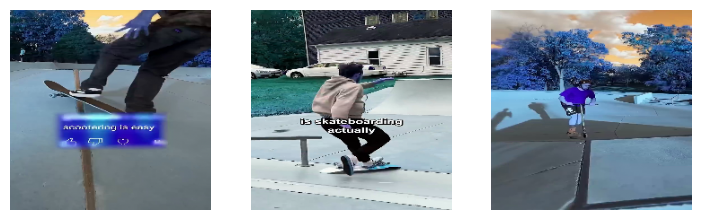

1/1 [==============================] - 18s 18s/step
[[0.01438392 0.00312627 0.25851053 0.00078833 0.0089517  0.0063384
  0.03607746 0.10998195 0.03686565 0.00654471 0.00106074 0.05165914
  0.0288025  0.02289656 0.41401213]]
Predicted label:  [14]
Predicted Action:  JavelinThrow


In [5]:
##basketball
# video_link = 'https://www.youtube.com/watch?v=VZsrT08QHto'


#golf
# video_link= 'https://youtube.com/shorts/bJcULhp4-78?feature=shared'

##tenis swing
# video_link= 'https://www.youtube.com/shorts/SD3RSxcu9mQ'

##soccer
# video_link= 'https://www.youtube.com/shorts/1a-ttcG4UUQ'

#drawback-misclassification of volleyballspiking
# video_link= 'https://www.youtube.com/shorts/rjoI1fFe438'

# # skiing
# video_link='https://www.youtube.com/watch?v=LmHw51Ea3nc&pp=ygUGc2tpaW5n'

# skiing
# video_link='https://www.youtube.com/watch?v=85FDZu1ofj0&pp=ygUGc2tpaW5n'

# skateboarding
video_link='https://www.youtube.com/watch?v=iI4kvI1W-Hg&pp=ygUNc2thdGVib2FyZGluZw%3D%3D'

#biking
# video_link='https://www.youtube.com/watch?v=wfYPuWY03BI'

#volleyball
# video_link='https://www.youtube.com/shorts/2mVNYJmlw1A'

# rowing
# video_link='https://www.youtube.com/watch?v=c3XCEEHxhH8&pp=ygUGcm93aW5n'

input_video_file_path = download_youtube_frames(video_link)

# input_video_file_path = 'UCF50/Rowing/v_Rowing_g01_c01.avi'
final_output = predict_single_action(input_video_file_path, SEQUENCE_LENGTH)
delete_frames_in_folder("saved_frames")